In [1]:
%load_ext rpy2.ipython

In [2]:
# Prepare
import pandas as pd
import os
os.chdir('/Users/denis/Documents/Projects/hiv-analysis/hiv-signature-analysis')
%R invisible(source('/Users/denis/Documents/Projects/scripts/Support.R'));
%R invisible(library(gplots));

/Users/denis/my-venv/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘gplots’


  warnings.warn(x, RRuntimeWarning)
/Users/denis/my-venv/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following object is masked from ‘package:stats’:

    lowess


  warnings.warn(x, RRuntimeWarning)


# HIV Dataset - Exploratory Data Analysis

## Overview

The purpose of this notebook is to perform Exploratory Data Analysis (EDA) on the HIV data provided by Weijia Zhang.

The data is comprised of two datasets:
1. A dataset containing *13 samples* of **podocyte-derived cell lines**, divided in three batches.  3 samples are untreated, the rest are treated with HIV at different timepoints (6, 12, 24, 48h).
2. A dataset containing *21 samples* of **primary podocytes**, derived from 10 different patients.  The samples span three conditions: HIV-infected, GFP-infected controls, and untreated.

In [3]:
# Infiles
infiles = ['f2-normalized_expression_data.dir/primary_podocyte-vst.txt', 'f2-normalized_expression_data.dir/podocyte_cell_line-vst.txt', 'rawdata.dir/hiv_sample_annotation.txt']

# Get dataframes
primaryDataframe = pd.read_table(infiles[0]).set_index('gene_symbol').drop(['NK1', 'NK2'], axis=1)
derivedDataframe = pd.read_table(infiles[1]).set_index('gene_symbol')
annotationDataframe = pd.read_table(infiles[2]).set_index('sample_name').drop(['NK1', 'NK2'], axis=0)
derivedAnnotationDataframe = annotationDataframe[annotationDataframe['cell_type'] == 'cell_line'].drop(['patient','patient_group'], axis=1)
primaryAnnotationDataframe = annotationDataframe[annotationDataframe['cell_type'] == 'primary_podocyte'].drop(['timepoint','batch'], axis=1)

## 1. Plots

### 1.1 PCA Analysis

In [4]:
%%R
plotPCA <- function(expressionDataframe, sampleLabels, main='', legendTitle = '', PCs=c('PC1', 'PC2'))
{
    # Run PCA
    pcaRes <- runPCA(expressionDataframe)

    # Get plot matrix
    plotMatrix <- pcaRes$x

    # Get color legend
    sampleNames <- rownames(plotMatrix)
    colorLegend <- getLegend(sampleNames, sampleLabels)#, colors=c('black','red','blue'))

    # Plot
    plot(plotMatrix[,PCs],
         col=colorLegend$colors,
         xlab=pcaRes$varLabels[PCs[1]],
         ylab=pcaRes$varLabels[PCs[2]],
         main=main)

    # Legend
    legend('topright', legend=names(colorLegend$legend), fill=colorLegend$legend, title=legendTitle)
}

The PCA analysis aims at investigating the separation between samples across the datasets.

1. The samples in the cell-line dataset are separated in 3 distinct clusters, largely determined by the batch.  The treatment status of the samples (HIV vs untreated) contributes to very little variance.
2. The samples in the primary podocyte dataset do not show clear separation in terms of treatment.

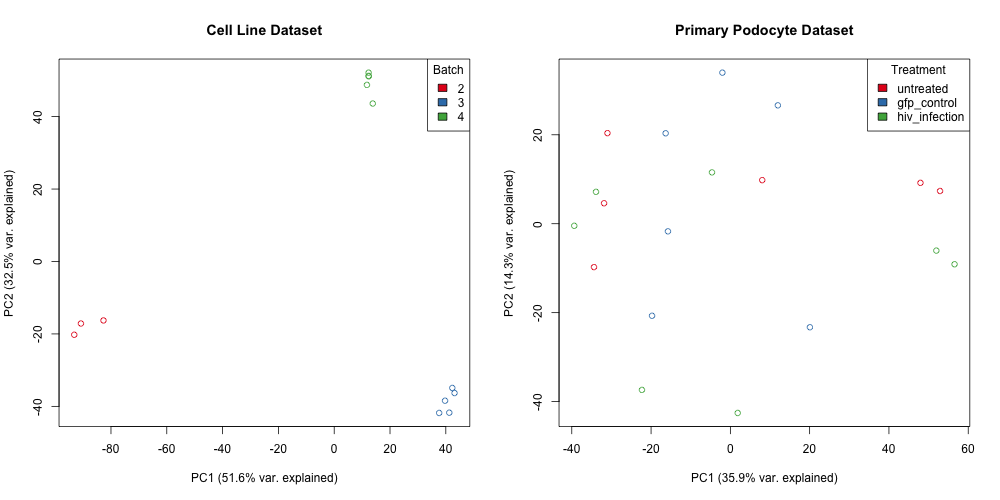

In [5]:
%%R -i derivedDataframe,primaryDataframe,derivedAnnotationDataframe,primaryAnnotationDataframe -h 500 -w 1000
# Set grid
par(mfrow=c(1,2))

# Plot
plotPCA(derivedDataframe, derivedAnnotationDataframe[colnames(derivedDataframe), 'batch'], 'Cell Line Dataset', 'Batch')
plotPCA(primaryDataframe, primaryAnnotationDataframe[colnames(primaryDataframe), 'treatment'], 'Primary Podocyte Dataset', 'Treatment')

### 1.2 Heatmap

The heatmap plots aim at investigating the separation between samples across the datasets, similarly to above.

1. As above, the samples in the cell-line dataset are separated in 3 distinct clusters, largely determined by the batch.
2. The samples in the primary podocyte dataset show some degree of separation based on the patient from which they are derived.

In [6]:
%%R
plotHeatmap <- function(expressionDataframe, sampleLabels, nGenes=1000, main='', pos=c(0, 0.7), legendTitle='Batch', method='complete')
{
    # Get gene variance
    geneVariance <- sort(apply(expressionDataframe, 1, var), decreasing=TRUE)

    # Get top genes
    topGenes <- names(geneVariance)[1:nGenes]

    # Get matrix
    plotMatrix <- as.matrix(expressionDataframe[topGenes,])

    # Get color legend
    sampleNames <- colnames(expressionDataframe)
    colorLegend <- getLegend(sampleNames, sampleLabels)

    # Plot margins
    par(mar=c(5,4,0,2))

    # Plot
    heatmap.2(plotMatrix,
              col=colorRampPalette(c('black','yellow','red')),
              trace='none',
              labRow = '',
              xlab = paste0(ncol(plotMatrix), ' samples'),
              ylab=paste0('Top ', nrow(plotMatrix), ' most variable genes'),
              mar=c(5,2),
              srtCol=45,
              key.title='Color Key',
              key.xlab='Expression level (VST)',
              ColSideColors=colorLegend$colors,
              hclustfun = function(x) hclust(x, method=method),
              main=main)

    # Add legend
    legend(pos[1], pos[2], legend=names(colorLegend$legend), fill=colorLegend$legend, title=legendTitle)
}

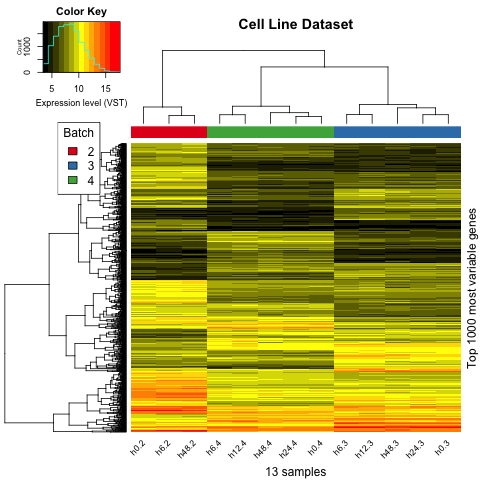

In [7]:
%%R
# Plot
plotHeatmap(derivedDataframe, derivedAnnotationDataframe[colnames(derivedDataframe), 'batch'], main='Cell Line Dataset')

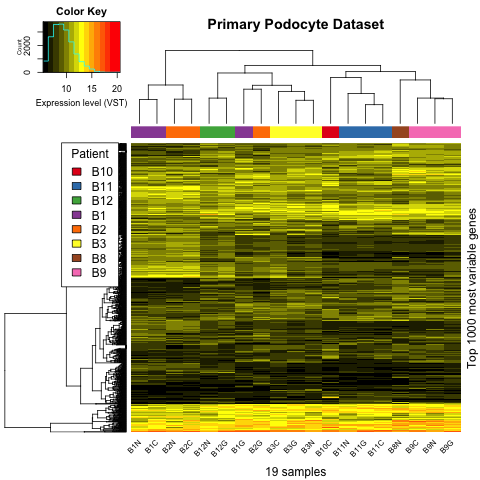

In [8]:
%%R
# Plot
plotHeatmap(primaryDataframe, primaryAnnotationDataframe[colnames(primaryDataframe), 'patient'], pos=c(0.01, 0.65), legendTitle='Patient', main='Primary Podocyte Dataset')